In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
our_color_palette = {"WT": "#F2C14E", # yellow
                     "W": "#F2C14E", # yellow
                     "IP": "#79ADDC", # blue
                     "I": "#79ADDC", # blue
                     "KO": "#B279A7", # purple
                     "K": "#B279A7", # purple
                    } 
treatments_list = ["W", "I", "K"]
passages_list = ["p1", "p2", "p3", "p5", "p10"]
replicates_list = ['a', 'b', 'c']

In [3]:
df = pd.read_csv("../../resources/additional_data/titers.formated.csv")

# log-transform titer values to "normalize" data distribution 
df["log_titer"] = np.log(df['titer'])
df['rep'] = df['genotype'] + df['replicate']

df.head(5)

,virus,passage,genotype,replicate,titer,log_titer,rep
0,crpv,1,WT,a,3.160000e+08,19.571253,WTa
1,crpv,2,WT,a,4.640000e+09,22.257980,WTa
2,crpv,3,WT,a,4.640000e+09,22.257980,WTa
3,crpv,4,WT,a,3.160000e+09,21.873838,WTa
4,crpv,5,WT,a,4.640000e+09,22.257980,WTa


In [4]:
df.columns

Index(['virus ', 'passage', 'genotype', 'replicate', 'titer', 'log_titer',
       'rep'],
      dtype='object')

/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_20624/2879440015.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.1}` instead.

  sns.barplot(
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:1271: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data
/Users/l

<AxesSubplot: xlabel='passage', ylabel='log_titer'>

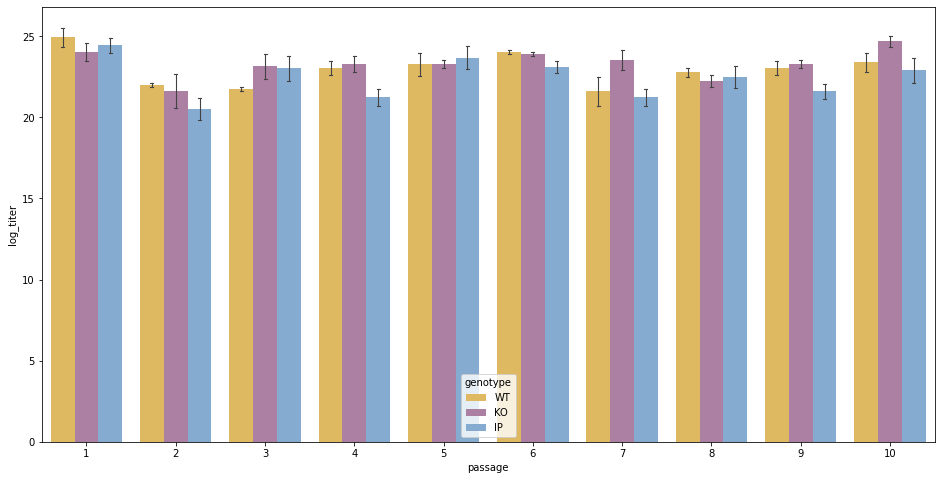

In [5]:
fig, ax = plt.subplots(1,1,  sharey=True, figsize=(16,8))

sns.barplot(
    data=df[df['virus ']=='dcv'], 
    hue='genotype', 
    x='passage', 
    palette=our_color_palette,
    y='log_titer',
    errwidth=1.1, 
    errorbar="se",
    dodge=0.2,
    capsize=0.1
)

In [6]:
df_crpv = df[df['virus ']=='crpv']
df_dcv = df[df['virus ']=='dcv']

In [7]:
%load_ext rpy2.ipython

Error importing in API mode: ImportError("dlopen(/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): symbol not found in flat namespace '_R_BaseEnv'")
Trying to import in ABI mode.


## dcv

In [8]:
%%R -i df_dcv 



df_dcv$passage <- as.factor(df_dcv$passage)

# Convert genotype to factor
df_dcv$genotype <- factor(df_dcv$genotype)

# Relevel the genotype factor with W as reference
df_dcv$genotype <- relevel(df_dcv$genotype, ref = "WT")



In [9]:
### check autocorrelation


	Durbin-Watson test

data:  residuals_mod ~ 1
DW = 2.5951, p-value = 0.9981
alternative hypothesis: true autocorrelation is greater than 0



Lade nötiges Paket: zoo

Attache Paket: ‘zoo’

Die folgenden Objekte sind maskiert von ‘package:base’:

    as.Date, as.Date.numeric

Zusätzlich: Warnmeldungen:
1: Paket ‘lmtest’ wurde unter R Version 4.1.2 erstellt 
2: Paket ‘zoo’ wurde unter R Version 4.1.2 erstellt 


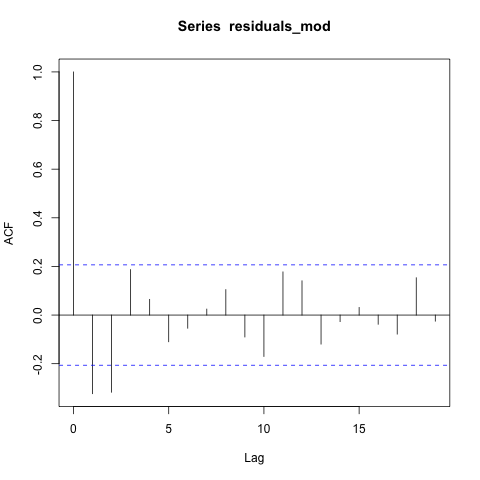

In [10]:
%%R

library(nlme)
library(lmtest)

df_dcv <- df_dcv[order(df_dcv$passage), ]

# Example fitting linear mixed-effects model for your design
mod <- lme(log_titer ~ genotype * passage, 
           random = ~1 | rep, 
           data = df_dcv)

# Extract residuals
residuals_mod <- residuals(mod)

# Plot ACF of residuals
acf(residuals_mod)

# Durbin-Watson test on model
dwtest(residuals_mod ~ 1)

In [11]:
### --> no indication for autocorrelation 

In [16]:
### model with autocorrelation 

In [13]:
%%R

mod <- lme(log_titer ~ genotype * passage, 
           random = ~1 | rep, 
           correlation = corAR1(form = ~ 1 | rep),
           data = df_dcv)

In [21]:
%%R
library(emmeans)

emm <- emmeans(mod, pairwise ~ genotype | passage)

sig_contrasts <- summary(emm$contrasts)
sig_filtered <- sig_contrasts[sig_contrasts$p.value < 0.05, ]

if (nrow(sig_filtered) > 0) {
  print(sig_filtered)
} else {
  message("No significant contrasts found with p-value < 0.05.")
}



No significant contrasts found with p-value < 0.05.


Converting missing values (`NA`) into regular values currently not
  possible for variables of class `NULL`.


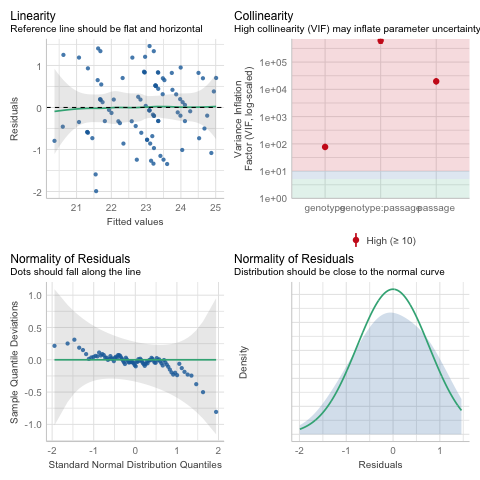

In [23]:
%%R 
library(performance)
check_model(mod)

In [ ]:
### model without autocorrelation

In [26]:
%%R 

# use mixed ANOVA
# within-subject factor: passage
# indepentent between factor: genotype 
# dependent variable: dcv titers

library(rstatix)

# Two-way mixed ANOVA test
res.aov <- anova_test(
  data = df_dcv, 
    dv = log_titer, 
    wid = rep,
    between = genotype, 
    within = passage
  )
get_anova_table(res.aov)

ANOVA Table (type II tests)

            Effect DFn DFd     F        p p<.05   ges
1         genotype   2   6 5.586 4.30e-02     * 0.176
2          passage   9  54 7.928 2.37e-07     * 0.539
3 genotype:passage  18  54 1.524 1.18e-01       0.310



Attache Paket: ‘rstatix’

Das folgende Objekt ist maskiert ‘package:stats’:

    filter

Zusätzlich: Warnmeldung:
Paket ‘rstatix’ wurde unter R Version 4.1.2 erstellt 


In [27]:
%%R 

# use mixed ANOVA
# within-subject factor: passage
# indepentent between factor: genotype 
# dependent variable: dcv titers

library(afex)

o1 <- aov_ez("rep", 
             "titer", 
             df_dcv, 
             transformation = "log",
             between = "genotype", 
            within ="passage")
o1

Anova Table (Type 3 tests)

Response: log.titer
            Effect     df  MSE        F  ges p.value
1         genotype   2, 6 1.07   5.59 * .176    .043
2          passage  9, 54 0.92 7.93 *** .539   <.001
3 genotype:passage 18, 54 0.92     1.52 .310    .118
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1

Sphericity correction method: GG 


Lade nötiges Paket: lme4
Lade nötiges Paket: Matrix

Attache Paket: ‘lme4’

Das folgende Objekt ist maskiert ‘package:nlme’:

    lmList

************
Welcome to afex. For support visit: http://afex.singmann.science/
- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'S', 'KR', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- Get and set global package options with: afex_options()
- Set sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************

Attache Paket: ‘afex’

Das folgende Objekt ist maskiert ‘package:lme4’:

    lmer

Contrasts set to contr.sum for the following variables: genotype


Data was changed during ANOVA calculation. Thus, residuals cannot be added to original data.
residuals(..., append = TRUE) will return data and residuals.
Data was changed during ANOVA calculation. Thus, fitted values cannot be added to original data.
fitted(..., append = TRUE) will return data and fitted values.
Data was changed during ANOVA calculation. Thus, residuals cannot be added to original data.
residuals(..., append = TRUE) will return data and residuals.
Data was changed during ANOVA calculation. Thus, fitted values cannot be added to original data.
fitted(..., append = TRUE) will return data and fitted values.
Data was changed during ANOVA calculation. Thus, residuals cannot be added to original data.
residuals(..., append = TRUE) will return data and residuals.
Failed to compute posterior predictive checks with `re_formula=NULL`.
  Trying again with `re_formula=NA` now.


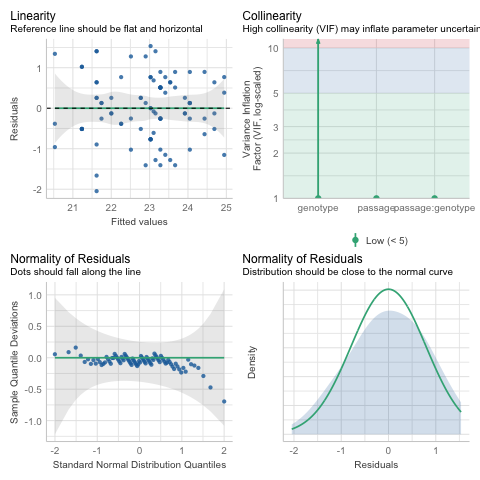

In [28]:
%%R 

check_model(o1)

In [22]:
%%R 

library(performance) # for assumption checks

check_homogeneity(o1)

OK: There is not clear evidence for different variances across groups (Levene's Test, p = 0.136).


In [23]:
%%R 

library(performance) # for assumption checks

check_sphericity(o1)

OK: Data seems to be spherical (p > .999).


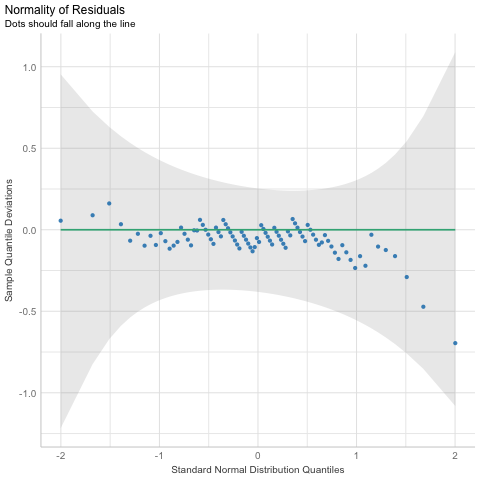

In [24]:
%%R 

library(performance) # for assumption checks

is_norm <- check_normality(o1)

plot(is_norm)

#plot(is_norm, type = "qq", detrend = TRUE)

In [56]:
%%R

sig_results

 [1] contrast   passage    estimate   SE         df         t.ratio   
 [7] p.value    sig.level  genotype1  genotype2  y.position
<0 rows> (or 0-length row.names)


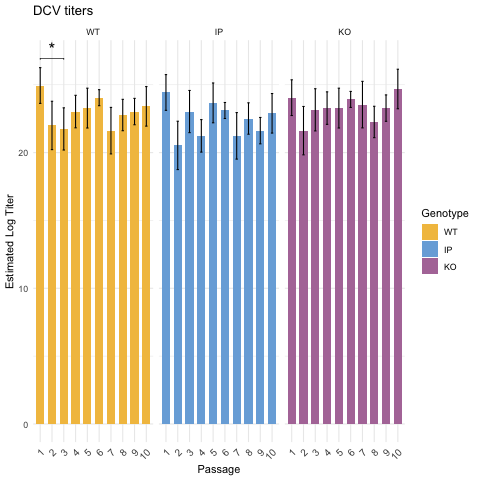

In [67]:
%%R
library(emmeans)
library(ggplot2)
library(dplyr)
library(ggpubr)

# Example color palette
our_color_palette <- c("WT" = "#F2C14E",  # yellow
                       "IP" = "#79ADDC",  # blue
                       "KO" = "#B279A7")  # purple

# Pairwise comparisons of genotype at each passage level
emm_pw <- emmeans(o1, pairwise ~ passage | genotype, adjust = "bonferroni")
emm_summary <- as.data.frame(summary(emm_pw$emmeans))  # Convert to data frame

# Extract the p-value results from the pairwise comparisons
p_value_results <- as.data.frame(summary(pairs(emm_pw, by = "genotype")))  # Convert to data frame

# Add significance levels and filter for significant differences
sig_results <- p_value_results %>%
  mutate(sig.level = case_when(
    p.value <= 0.001 ~ "***",
    p.value <= 0.01 ~ "**",
    p.value <= 0.05 ~ "*",
    TRUE ~ "ns"
  )) %>%
  filter(sig.level != "ns")  # Keep only significant comparisons

# Extract passage information from the contrast column
sig_results <- sig_results %>%
  mutate(
    passage1 = gsub(" - .*", "", contrast),
    passage2 = gsub(".* - ", "", contrast)
  )

# Ensure passage is a factor with consistent levels
emm_summary$passage <- factor(emm_summary$passage, levels = unique(emm_summary$passage))

# Create the plot
p <- ggplot() +
  geom_bar(data = emm_summary, aes(x = passage, y = emmean, fill = genotype),
           stat = "identity", position = "dodge", width = 0.7) + # Adjust bar width for better spacing
  geom_errorbar(data = emm_summary, aes(x = passage, ymin = lower.CL, ymax = upper.CL, group = genotype),
                position = position_dodge(0.9), width = 0.2) +
  scale_fill_manual(values = our_color_palette) +
  facet_grid(~genotype) +
  labs(title = "DCV titers",
       x = "Passage",
       y = "Estimated Log Titer",
       fill = "Genotype") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 10)) +  # Adjust text size and angle
  scale_x_discrete(labels = function(x) as.numeric(gsub("X", "", x)))  # Replace "X1" with "1"

# Prepare data for brackets
bracket_data <- sig_results %>%
  mutate(
    xmin = as.numeric(factor(passage1, levels = levels(emm_summary$passage))),
    xmax = as.numeric(factor(passage2, levels = levels(emm_summary$passage))),
    y.position = max(emm_summary$emmean) + 2
  )

# Add brackets for significant differences
p <- p + geom_bracket(
  data = bracket_data,
  aes(xmin = xmin, xmax = xmax, y.position = y.position, label = sig.level),
  inherit.aes = FALSE,
  label.size = 6, # Increase star size
  tip.length = 0.01,
  bracket.size = 0.7 # Increase bracket size
)

# Display the plot
print(p)

# Adjust figure size when saving (optional)
#ggsave("myplot.png", p, width = 8, height = 5)




In [64]:
%%R
bracket_data

  contrast genotype estimate        SE df  t.ratio    p.value sig.level
1  X1 - X3       WT 3.199015 0.5866969  6 5.452585 0.02266055         *
  passage1 passage2 xmin xmax y.position
1       X1       X3    1    1   26.94448


In [25]:
%%R
library(emmeans)
library(ggplot2)
library(dplyr)

# Pairwise comparisons of genotype at each passage level
emm_pw <- emmeans(o1, pairwise ~ genotype | passage, adjust = "bonferroni")
emm_summary <- summary(emm_pw)

# Extract the p-value results from the pairwise comparisons
p_value_results <- summary(pairs(emm_pw, by = "passage"))

# Add significance levels and filter for significant differences
sig_results <- p_value_results %>%
  mutate(sig.level = case_when(
    p.value <= 0.001 ~ "***",
    p.value <= 0.01 ~ "**",
    p.value <= 0.05 ~ "*"
  ),
  y.position = 0) %>%  # Initialize y.position
  filter(!is.na(sig.level))  # Keep only significant comparisons
sig_results

R[write to console]: Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'

R[write to console]: 
Attache Paket: ‘dplyr’


R[write to console]: Die folgenden Objekte sind maskiert von ‘package:stats’:

    filter, lag


R[write to console]: Die folgenden Objekte sind maskiert von ‘package:base’:

    intersect, setdiff, setequal, union




[1] contrast   passage    estimate   SE         df         t.ratio    p.value   
[8] sig.level  y.position
<0 Zeilen> (oder row.names mit Länge 0)


In [18]:
%%R 

# post-ad-hoc tests
library(emmeans)
library(ggplot2)
library(dplyr)

# Pairwise comparisons of genotype at each passage level
emm_pw <- emmeans(o1, pairwise ~ passage | genotype, adjust = "bonferroni")
emm_summary <- summary(emm_pw)

# Extract the p-value results from the pairwise comparisons
p_value_results <- summary(pairs(emm_pw, by = "genotype"))

# Add significance levels and filter for significant differences
sig_results <- p_value_results %>%
  mutate(sig.level = case_when(
    p.value <= 0.001 ~ "***",
    p.value <= 0.01 ~ "**",
    p.value <= 0.05 ~ "*"
  ),
  y.position = 0) %>%  # Initialize y.position
  filter(!is.na(sig.level))  # Keep only significant comparisons
sig_results

  contrast genotype estimate        SE df  t.ratio    p.value sig.level
1  X1 - X3       WT 3.199015 0.5866969  6 5.452585 0.02266055         *
  y.position
1          0


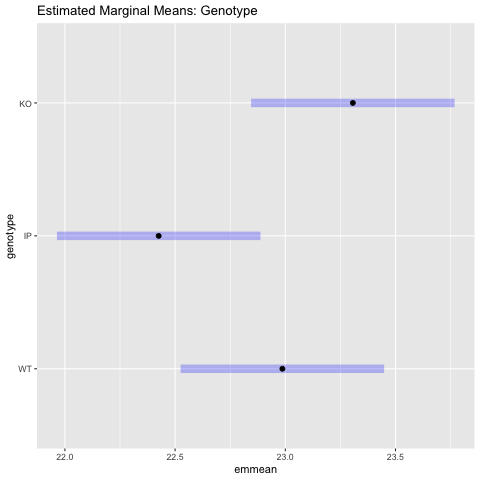

In [19]:
%%R 

library(emmeans)
library(ggplot2)
library(dplyr)

# Compute EMMs for the interaction of genotype and passage
emm_interaction <- emmeans(o1, ~ genotype * passage)

# Convert to a data frame for easier plotting
emm_df <- as.data.frame(emm_interaction)

# Create the plot
ggplot(emm_df, aes(x = passage, y = emmean, color = genotype, group = genotype)) +
  geom_line() +
  geom_point() +
  geom_errorbar(aes(ymin = lower.CL, ymax = upper.CL), width = 0.2) +
  labs(title = "Estimated Marginal Means: Genotype x Passage",
       x = "Passage",
       y = "Estimated Log Titer") +
  theme_minimal()

# If you want separate plots for each factor:

# For genotype
emm_genotype <- emmeans(o1, ~ genotype)
plot(emm_genotype) + labs(title = "Estimated Marginal Means: Genotype")

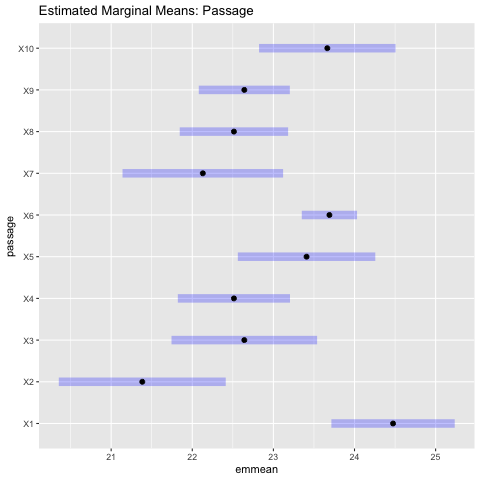

In [20]:
%%R

# For passage
emm_passage <- emmeans(o1, ~ passage)
plot(emm_passage) + labs(title = "Estimated Marginal Means: Passage")
